### Indice:
* [Intro](#Intro)
* [Step 1](#Step1)
* [Step 2](#Step2)
* [Step 3](#Step3)
* [Step 4](#Step4)
* [Conclusione](#Conclusione)

### Intro

L'obiettivo dello studio è analizzare i due dataset, uno relativo alla produzione mondiale di cibo/mangimi, l'altro all'impatto ambientale che ciascuno genera.

Il modo in cui procederemo sarà il seguente:
* Identificazione dei cibi/mangimi più prodotti, così da ottenere un'idea sui prodotti più consumati;
* Classificazione dei prodotti in macro-classi; 
* Analisi sull'impatto ambientale di ciascuna classe.

Dopo aver studiato l'impatto ambientale, potremmo - per esempio - prendere in considerazione le classi ad impatto maggiore ed analizzarne l'andamento di produzione mondiale nel corso degli anni.

### Step 1 - Studio del dataset relativo alla produzione mondiale
<a id="Step1"></a>

In [1]:
# Importo i pacchetti necessari

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
init_df = pd.read_csv('FAO.csv', encoding='latin1')
init_df.head()

,Area Abbreviation,Area Code,Area,Item Code,Item,Element Code,Element,Unit,latitude,longitude,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
0,AFG,2,Afghanistan,2511,Wheat and products,5142,Food,1000 tonnes,33.94,67.71,...,3249.0,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895
1,AFG,2,Afghanistan,2805,Rice (Milled Equivalent),5142,Food,1000 tonnes,33.94,67.71,...,419.0,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422
2,AFG,2,Afghanistan,2513,Barley and products,5521,Feed,1000 tonnes,33.94,67.71,...,58.0,236.0,262.0,263.0,230.0,379.0,315.0,203.0,367,360
3,AFG,2,Afghanistan,2513,Barley and products,5142,Food,1000 tonnes,33.94,67.71,...,185.0,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89
4,AFG,2,Afghanistan,2514,Maize and products,5521,Feed,1000 tonnes,33.94,67.71,...,120.0,208.0,233.0,249.0,247.0,195.0,178.0,191.0,200,200


#### Osservazione

* Vogliamo fare uno studio a livello mondiale, non ci interessa sapere quindi l'andamento paese per paese;
* Vogliamo riorganizzare gli anni in un'unica colonna e vederne la relativa produzione.

In [3]:
# Rimuovo tutte le colonne non necessarie e rinomino le colonne anno
col_list = list(init_df.columns)
col_remove = ['Area', 'Area Abbreviation','Area Code','Item Code','Element Code', 'Unit', 'latitude','longitude']
for i in col_remove:
    col_list.remove(i)

rename_dict = dict()
for i in range(1961,2014):
    rename_dict.update({'Y'+str(i):i})
    
df = init_df[col_list]
df.rename(columns=rename_dict, inplace=True)

# Creo un'unica colonna Year contenete i vari anni
df = df.melt(id_vars=["Item", "Element"], 
        var_name="Year", 
        value_name="Production")

df['Production'] = df['Production'].astype('float')
df['Year'] = df['Year'].astype('int')
df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_8640\2467215520.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=rename_dict, inplace=True)


,Item,Element,Year,Production
0,Wheat and products,Food,1961,1928.0
1,Rice (Milled Equivalent),Food,1961,183.0
2,Barley and products,Feed,1961,76.0
3,Barley and products,Food,1961,237.0
4,Maize and products,Feed,1961,210.0


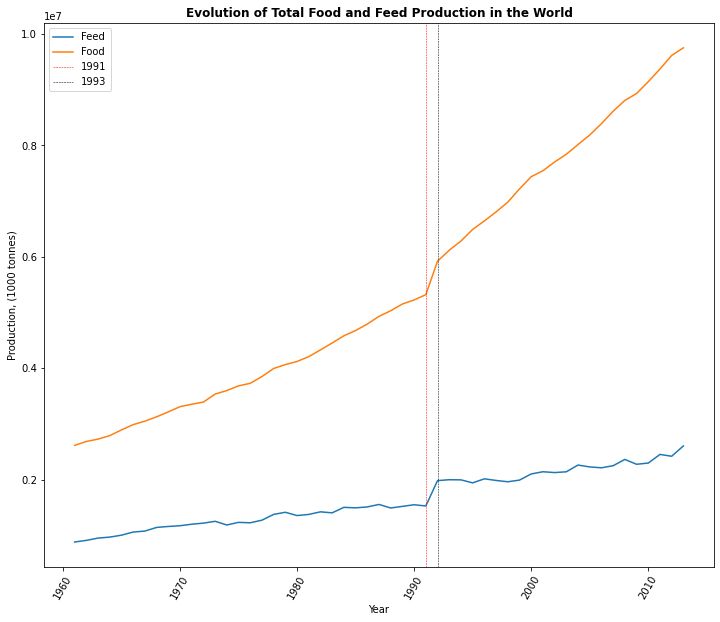

In [4]:
# Studiamo la crescita di produzione di cibo e mangime nel corso degli anni
yearly_prod_element = df.groupby(["Year", "Element"], as_index=False).agg({"Production":"sum"})

figure = plt.figure(figsize=(12,10))
sns.lineplot(x="Year", y="Production", hue="Element", data=yearly_prod_element)

plt.axvline(1991, color='red', linestyle='--', linewidth=0.5, label='1991')
plt.axvline(1992, color='black', linestyle='--', linewidth=0.5, label='1993')

plt.title("Evolution of Total Food and Feed Production in the World", fontsize = 12, fontweight = "bold")
plt.xlabel("Year", fontsize = 10)
plt.ylabel("Production, (1000 tonnes)", fontsize = 10)
plt.xticks(rotation=60)
plt.legend()
plt.show()

#### Osservazione

Ci accorgiamo che tra l'anno 1991 e 1993 vi è una crescita più rapida rispetto agli altri intervalli di tempo.
Per poter fare un'analisi più accurata e contemporanea, seleziono solo i dati a partire dal 1991.

In [5]:
# Prendo i dati dal '91 in poi
df91 = df[df['Year'] >= 1991]

In [6]:
def df_filter(df, column, value):
    """a quick function that filters a data frame based on the values in one of its columns"""
    filtered_df = df[df[column]==value]
    return filtered_df

In [7]:
# Raggruppo i dati per prodotti sommando la quantità totale di produzine per ciascuno, dividendo sempre mangime e cibo
df2 = df91.groupby(['Element', 'Item'], as_index=False).agg(Production=pd.NamedAgg(column='Production', aggfunc='sum'))
df2.head()

,Element,Item,Production
0,Feed,Animal fats,51079.0
1,Feed,Apples and products,9904.0
2,Feed,Aquatic Plants,8114.0
3,Feed,"Aquatic Products, Other",8114.0
4,Feed,Bananas,22062.0


In [8]:
# Consideriamo i 25 item più prodotti, che saranno quelli col "peso" maggiore per l'impatto ambientale
df3 = df2.sort_values(by=['Production'], ascending=False)
df_food = df_filter(df3, 'Element', 'Food')
df_feed = df_filter(df3, 'Element', 'Feed')
df_top_food = df_food.head(25)
df_top_feed = df_feed.head(25)

# Tolgo la colonna Element, in quanto non più necessaria
df_top_food.drop('Element', inplace=True, axis=1)
df_top_feed.drop('Element', inplace=True, axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_8640\4282496836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_food.drop('Element', inplace=True, axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_8640\4282496836.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_feed.drop('Element', inplace=True, axis=1)


C:\Users\User\AppData\Local\Temp\ipykernel_8640\486207497.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which="minor")


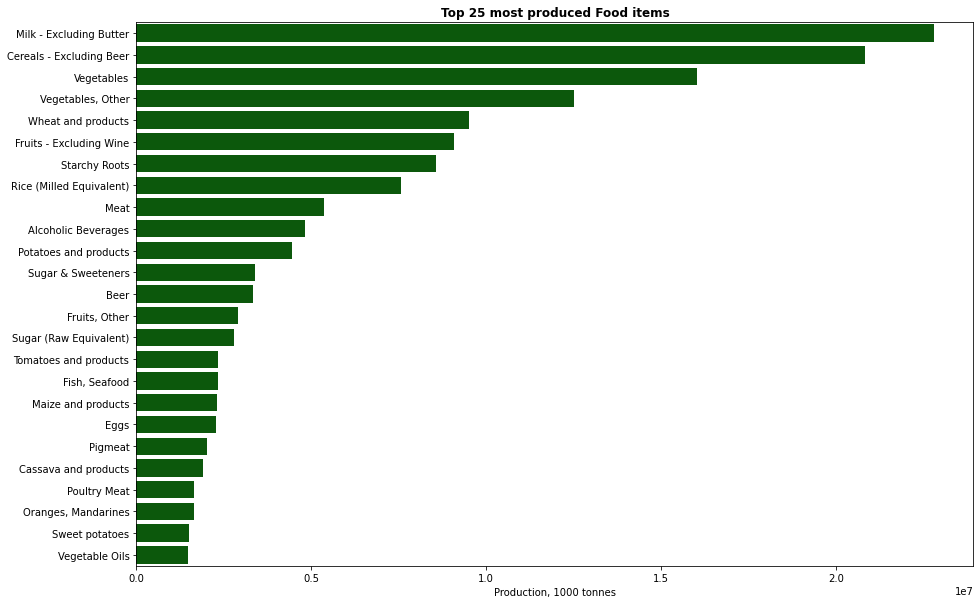

In [9]:
# Vediamo graficamente le due top (food/feed)
figure = plt.figure(figsize=(15,10))

sns.barplot(x="Production", y="Item", data=df_top_food, color="darkgreen")

plt.title("Top 25 most produced Food items", fontsize = 12, fontweight = "bold")
plt.ylabel("")
plt.xlabel("Production, 1000 tonnes", fontsize = 10)
plt.grid(b=None, which="minor")

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_8640\2458471899.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which="minor")


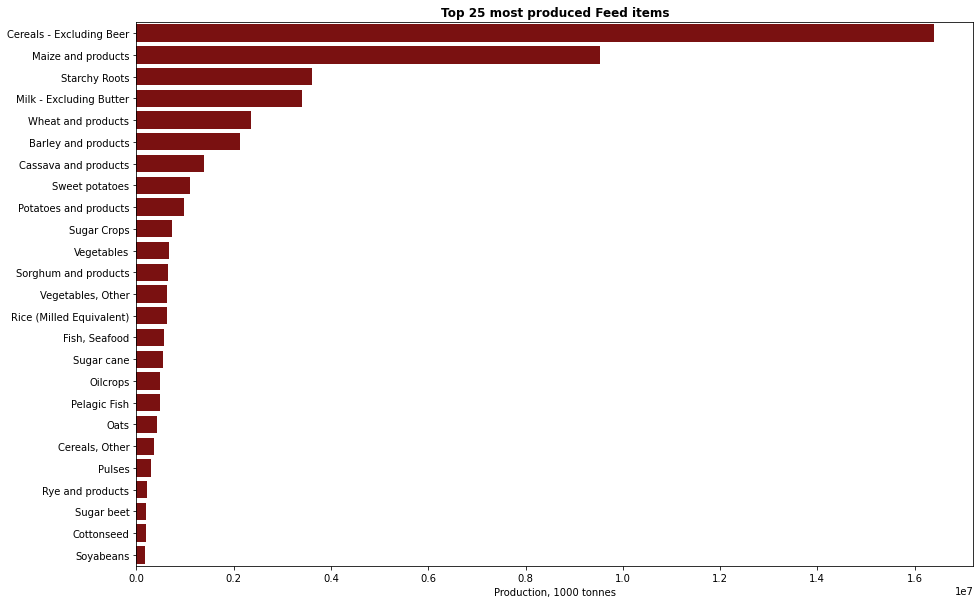

In [10]:
figure = plt.figure(figsize=(15,10))

sns.barplot(x="Production", y="Item", data=df_top_feed, color="darkred")

plt.title("Top 25 most produced Feed items", fontsize = 12, fontweight = "bold")
plt.ylabel("")
plt.xlabel("Production, 1000 tonnes", fontsize = 10)
plt.grid(b=None, which="minor")

plt.show()

### Step 2 - Classificazione in macro-classi
<a id="Step2"></a>

Data la diversità di prodotti, creo delle categorie in cui inserire i vari prodotti e poter fare uno studio più ampio/accurato.

All'interno del file Gruppi_Alimenti.xlsx è possibile leggere la divisione in categorie più chiaramente.

In [11]:
# Creo il dizionario con le varie categorie, utilizzabile anche per il secondo dataset
categories = {'meat': ['Meat', 'Beef (beef herd)', 'Lamb & Mutton'], 
            'cereal': ['Cereals - Excluding Beer', 'Wheat and products', 'Barley and products',
                    'Sorghum and products', 'Cereals, Other', 'Rye and products', 'Wheat & Rye (Bread)'], 
            'milk': ['Milk - Excluding Butter', 'Cheese', 'Milk', 'Beef (dairy herd)'], 
            'fish': ['Fish, Seafood', 'Pelagic Fish', 'Shrimps (farmed)', 'Fish (farmed)'], 
            'oil': ['Vegetable Oils', 'Oilcrops', 'Palm Oil', 'Olive Oil', 'Rapeseed Oil',
                    'Sunflower Oil'], 
            'soya': ['Soyabeans',  'Soybean Oil', 'Tofu', 'Soymilk'],
            'pig': ['Pigmeat', 'Pig Meat'], 
            'poultry': ['Poultry Meat'], 
            'egg': ['Eggs'], 
            'rice': ['Rice (Milled Equivalent)', 'Rice'], 
            'pulses': ['Pulses', 'Peas', 'Other Pulses'], 
            'oat': ['Oats', 'Oatmeal'],
            'sugar': ['Sugar & Sweeteners', 'Sugar (Raw Equivalent)', 'Cane Sugar', 'Beet Sugar', 
                    'Sugar Crops', 'Sugar cane', 'Sugar beet'],
            'tomato': ['Tomatoes and products', 'Tomatoes'], 
            'alcohol': ['Alcoholic Beverages', 'Wine'], 
            'fruit': ['Fruits - Excluding Wine', 'Fruits, Other', 'Oranges, Mandarines',
                    'Berries & Grapes', 'Bananas', 'Other Fruit', 'Citrus Fruit', 'Apples'],
            'maize': ['Maize and products', 'Maize (Meal)'], 
            'beer': ['Beer', 'Barley (Beer)'], 
            'cassava': ['Cassava and products', 'Cassava'],
            'vegetable': ['Vegetables', 'Vegetables, Other', 'Other Vegetables', 'Brassicas',
                    'Onions & Leeks'], 
            'root': ['Starchy Roots', 'Root Vegetables'], 
            'potato': ['Potatoes and products', 'Sweet potatoes', 'Potatoes']}

category_food = {'Item': [], 'Category': []}
category_feed = {'Item': [], 'Category': []}

def categorize(category, item_list, dict_category):
    """a function that group item in category"""
    key = list(category.keys())
    for item in item_list:
        for cat, products in dict_category.items():
            if item in products:
                category[key[0]].append(item)
                category[key[1]].append(cat.title())


# Creo i nuovi dataframe 'categorizzati'
categorize(category_food, list(df_top_food.Item), categories)
df_category_food = pd.DataFrame(category_food)

categorize(category_feed, list(df_top_feed.Item), categories)
df_category_feed = pd.DataFrame(category_feed)

In [12]:
# Aggiungo le categorie ai dataframe di partenza tramite una join
join_food_category = pd.merge(df_top_food, df_category_food, on='Item')
join_feed_category = pd.merge(df_top_feed, df_category_feed, on='Item')

In [13]:
# Faccio il totale sulle categorie e riordino in ordine decrescente
total_food_category = join_food_category.groupby('Category', as_index=False).agg(TotalFood=pd.NamedAgg(column='Production', aggfunc='sum'))
total_food_category = total_food_category.sort_values(by=['TotalFood'], ascending=False)

total_feed_category = join_feed_category.groupby('Category', as_index=False).agg(TotalFeed=pd.NamedAgg(column='Production', aggfunc='sum'))
total_feed_category = total_feed_category.sort_values(by=['TotalFeed'], ascending=False)

C:\Users\User\AppData\Local\Temp\ipykernel_8640\2896734638.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which="minor")


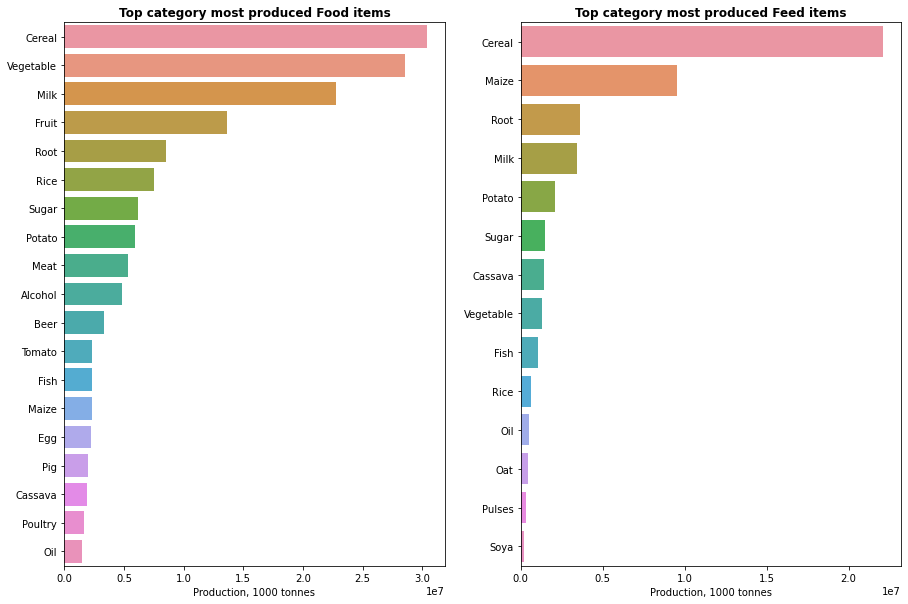

In [14]:
# Compariamo graficamente la produzione di cibo/mangime divisi in categorie
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))

ax1.set_title("Top category most produced Food items", fontsize = 12, fontweight = "bold")
sns.barplot(y="Category", x="TotalFood", data=total_food_category, ax=ax1)
ax1.set_xlabel("Production, 1000 tonnes")
ax1.set_ylabel("")

ax2.set_title("Top category most produced Feed items", fontsize = 12, fontweight = "bold")
sns.barplot(y="Category", x="TotalFeed", data=total_feed_category, ax=ax2)
ax2.set_xlabel("Production, 1000 tonnes")
ax2.set_ylabel("")

plt.grid(b=None, which="minor")
plt.show()

### Step 3 - Studio del dataset relativo all'impatto ambientale
<a id="Step3"></a>

In [15]:
fpi = pd.read_csv("Food_Production.csv")
fpi.head()

,Food product,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail,Total_emissions,Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),...,Freshwater withdrawals per 100g protein (liters per 100g protein),Freshwater withdrawals per kilogram (liters per kilogram),Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal),Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein),Land use per 1000kcal (m² per 1000kcal),Land use per kilogram (m² per kilogram),Land use per 100g protein (m² per 100g protein),Scarcity-weighted water use per kilogram (liters per kilogram),Scarcity-weighted water use per 100g protein (liters per 100g protein),Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,4.281357,...,371.076923,482.4,0.945482,1.907692,2.897446,7.6,5.846154,18786.2,14450.92308,7162.104461
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,9.514379,...,3166.760563,2248.4,1.207271,6.267606,0.759631,2.8,3.943662,49576.3,69825.77465,13449.891480


#### Osservazione

Siccome tutti i nostri dati del dataset precedente hanno come unità di misura $10^3$ tonnellate, teniamo in considerazione la colonna Total_emissions - che ci dà la quantità di $CO_2$ rilasciata per Kg di prodotto. Questa è l'unica colonna valorizzata per qualsiasi prodotto, è quindi il punto di riferimento migliore per poter fare i nostri studi; essa contiene, inoltre, la somma dei vari step (dalla produzione al packaging ed al trasporto).

In [16]:
# Seleziono le colonne da eliminare
columns_to_delete = ['Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal)',
                    'Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)',
                    'Freshwater withdrawals per 1000kcal (liters per 1000kcal)',
                    'Freshwater withdrawals per 100g protein (liters per 100g protein)',
                    'Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein)',
                    'Land use per 1000kcal (m² per 1000kcal)',
                    'Land use per 100g protein (m² per 100g protein)',
                    'Scarcity-weighted water use per 100g protein (liters per 100g protein)',
                    'Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)',
                    'Eutrophying emissions per kilogram (gPO₄eq per kilogram)',
                    'Freshwater withdrawals per kilogram (liters per kilogram)',
                    'Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)',
                    'Land use per kilogram (m² per kilogram)',
                    'Scarcity-weighted water use per kilogram (liters per kilogram)']

fpi = fpi.drop(columns=columns_to_delete)


# Rinomino le colonne per non avere più gli spazi
fpi.rename(columns = {'Food product': 'FoodProduct',
                     'Land use change': 'LandUseChange', 
                     'Animal feed': 'AnimalFeed',
                     'Total_emissions': 'TotalEmissions'}, 
            inplace = True)

fpi= fpi.fillna(0)
fpi.head()

,FoodProduct,LandUseChange,Animal Feed,Farm,Processing,Transport,Packging,Retail,TotalEmissions
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0


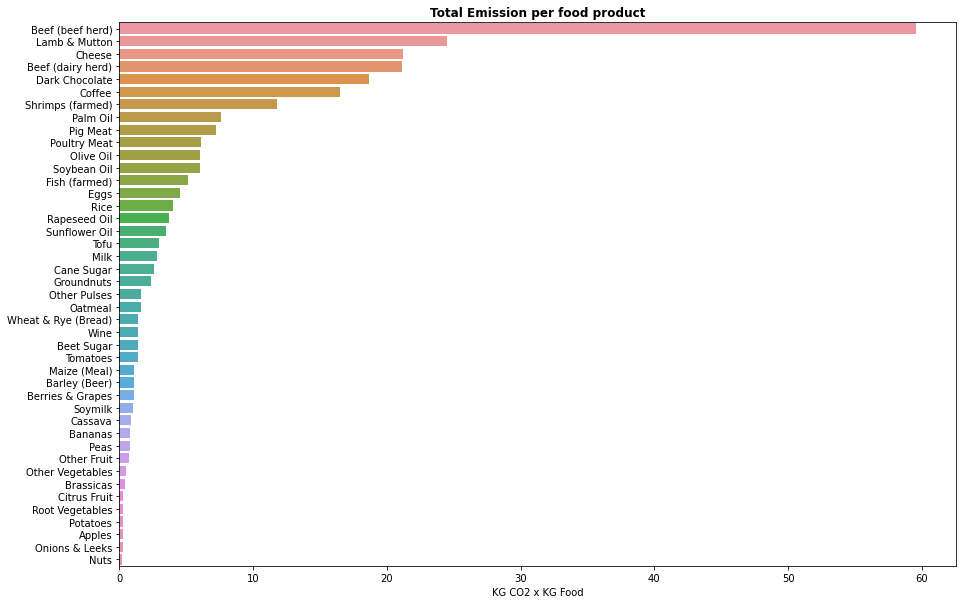

In [17]:
# Vediamo graficamente i prodotti che impattano di più per Kg
fpi = fpi.sort_values(['TotalEmissions'], ascending=False)

figure = plt.figure(figsize=(15,10))

sns.barplot(x="TotalEmissions", y='FoodProduct', data=fpi)

plt.title('Total Emission per food product', fontsize = 12, fontweight = "bold")
plt.xlabel('KG CO2 x KG Food',fontsize = 10)
plt.ylabel('')

plt.show()

In [18]:
# Dividiamo in categorie
category_impact = {'FoodProduct': [], 'Category': []}

categorize(category_impact, list(fpi.FoodProduct), categories)
df_category_impact = pd.DataFrame(category_impact)

In [19]:
# Come prima, tramite join applichiamo la categoria ai vari prodotti
join_impact_category = pd.merge(fpi, df_category_impact, on='FoodProduct')
join_impact_category = join_impact_category[['FoodProduct', 'Category', 'TotalEmissions']]

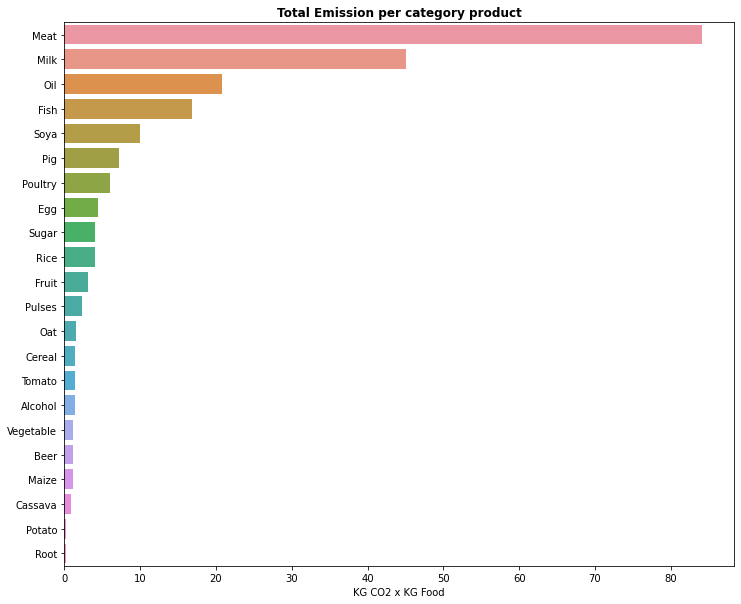

In [20]:
# Vediamo graficamente le categorie che impattano di più al Kg
total_impact_category = join_impact_category.groupby('Category', as_index=False).agg(TotalEmissions=pd.NamedAgg(column='TotalEmissions', aggfunc='sum'))
total_impact_category = total_impact_category.sort_values(by=['TotalEmissions'], ascending=False)

figure = plt.figure(figsize=(12,10))

sns.barplot(x="TotalEmissions", y='Category', data=total_impact_category)

plt.title('Total Emission per category product', fontsize = 12, fontweight = "bold")
plt.xlabel('KG CO2 x KG Food',fontsize = 10)
plt.ylabel('')

plt.show()

#### Osservazione

La carne rossa è senza dubbio la categoria più inquinante (in rapporto al Kg), soprattutto considerando anche la produzione di mangime per poter mantenere i vari allevamenti (es: "Soya"). Al secondo posto troviamo la categoria "Milk", in cui rientrano anche formaggi ed il relativo allevamento per produrlo. Ciò che potrebbe stupirci è vedere la produzione di oli vegetali ("Oil") al terzo posto: in realtà, come vedremo, la quantità di oli prodotti è comunque bassa rispetto al resto delle categorie. Nella nostra "classifica finale" gli oli vegetali non avranno una posizione così alta!

-----------------------------------------------------

#### Piccolo schema

In questo momento abbiamo la quantità di item prodotti (food/feed) divisi per categoria, con unità di misura 1000 tonnellate.
Le emissioni totali di $CO_2$ sono invece date dal rapporto $\dfrac{Kg \, CO_2}{Kg \, prodotto}$. Cambiando la scala di entrambi in tonnellate, il rapporto rimane invariato.

Dunque, indicando con $n$ il totale del prodotto e $k$ il rapporto di quanta $CO_2$ rilascia per $Kg$, il calcolo che faremo è:

$$
n \, 10^3 \mbox{t} \times k \dfrac{t \, CO_2}{t \, prodotto} = n \times k \times 10^3 \, CO_2
$$

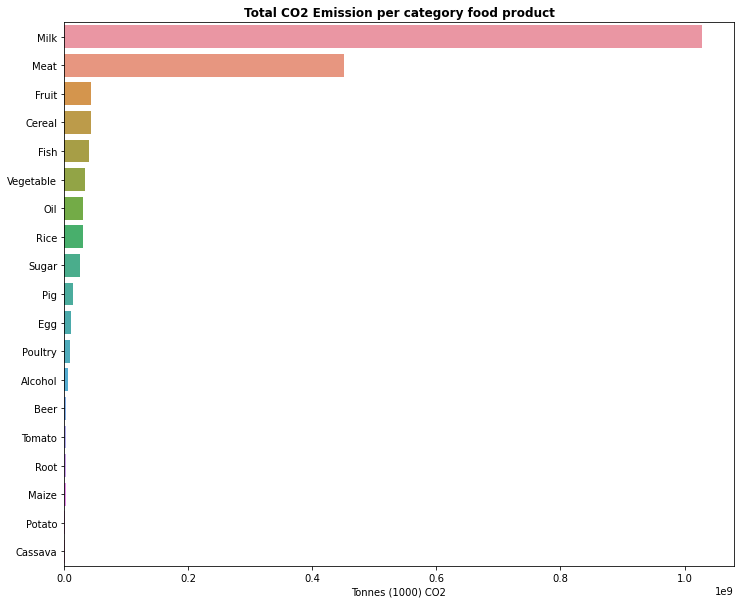

In [21]:
# Moltiplichiamo le tonnellate di item prodotti per il relativo "peso" di CO2 rilasciata
dfMerge = total_impact_category.merge(total_food_category, on='Category')
dfMerge['Impact'] = dfMerge['TotalEmissions'].mul(dfMerge['TotalFood'])
draw = dfMerge.sort_values(by=['Impact'], ascending=False)

# Vediamo graficamente il risultato finale
figure = plt.figure(figsize=(12,10))

sns.barplot(x="Impact", y='Category', data=draw)

plt.title('Total CO2 Emission per category food product', fontsize = 12, fontweight = "bold")
plt.xlabel('Tonnes (1000) CO2',fontsize = 10)
plt.ylabel('')

plt.show()

# Salvo una variabile col totale di CO2 emessa dalla produzione di cibo
sum_food_impact = dfMerge['Impact'].sum()

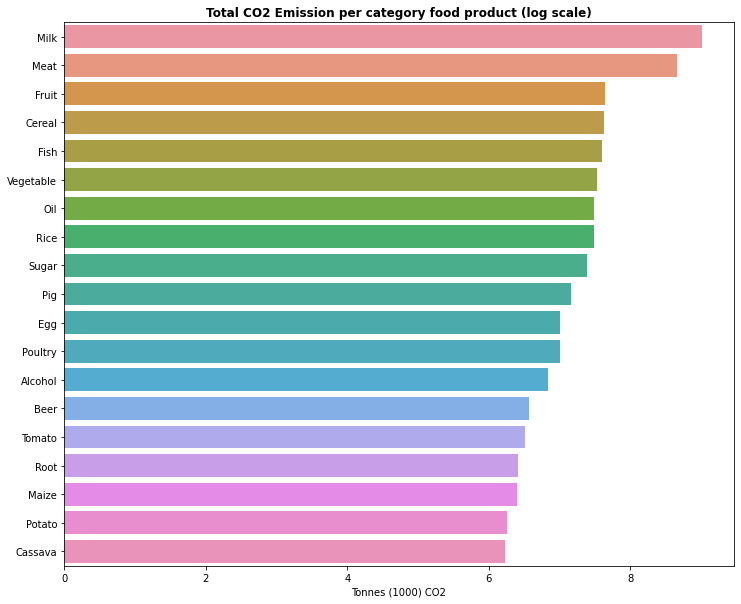

In [22]:
# La scala di valori è troppo ampia per poter fare un confronto tra tutti
# Scegliamo una scala logaritmica
dfMerge['LogImpact'] = np.log10(dfMerge['TotalEmissions'].mul(dfMerge['TotalFood']))
draw = dfMerge.sort_values(by=['LogImpact'], ascending=False)

figure = plt.figure(figsize=(12,10))

sns.barplot(x="LogImpact", y='Category', data=draw)

plt.title('Total CO2 Emission per category food product (log scale)', fontsize = 12, fontweight = "bold")
plt.xlabel('Tonnes (1000) CO2',fontsize = 10)
plt.ylabel('')

plt.show()

# Salvo una lista con la top 10 categorie di cibo
top_food_category = list(draw['Category'].head(10))

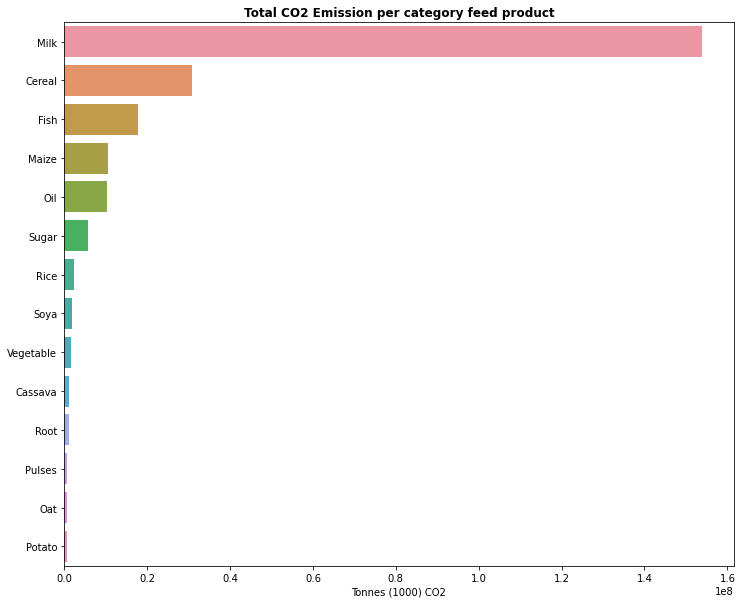

In [23]:
# Ripeto gli stessi ragionamenti per i mangimi
dfMerge = total_impact_category.merge(total_feed_category, on='Category')
dfMerge['Impact'] = dfMerge['TotalEmissions'].mul(dfMerge['TotalFeed'])
draw = dfMerge.sort_values(by=['Impact'], ascending=False)

figure = plt.figure(figsize=(12,10))

sns.barplot(x="Impact", y='Category', data=draw)

plt.title('Total CO2 Emission per category feed product', fontsize = 12, fontweight = "bold")
plt.xlabel('Tonnes (1000) CO2',fontsize = 10)
plt.ylabel('')

plt.show()

# Salvo una lista con la top 10 categorie di mangimi
top_feed_category = list(draw['Category'].head(10))

# Salvo una variabile col totale di CO2 emessa dalla produzione di mangimi
sum_feed_impact = dfMerge['Impact'].sum()

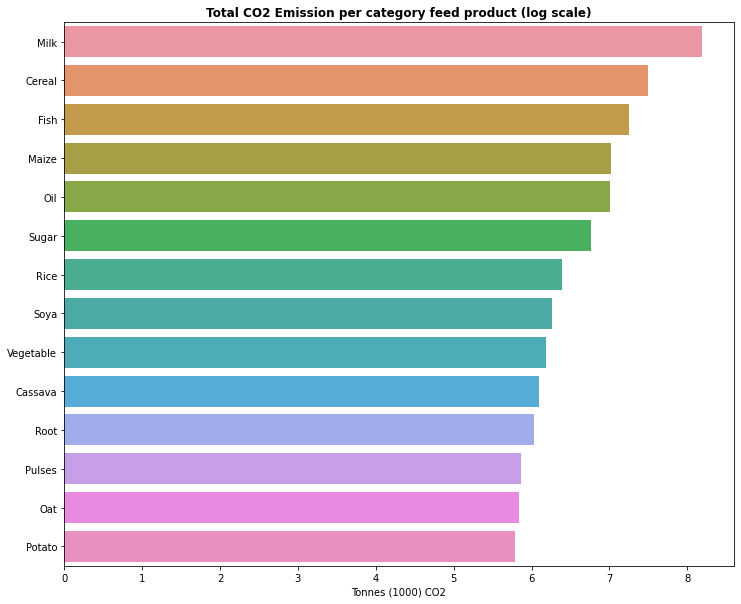

In [24]:
dfMerge['LogImpact'] = np.log10(dfMerge['TotalEmissions'].mul(dfMerge['TotalFeed']))
draw = dfMerge.sort_values(by=['LogImpact'], ascending=False)

figure = plt.figure(figsize=(12,10))

sns.barplot(x="LogImpact", y='Category', data=draw)

plt.title('Total CO2 Emission per category feed product (log scale)', fontsize = 12, fontweight = "bold")
plt.xlabel('Tonnes (1000) CO2',fontsize = 10)
plt.ylabel('')

plt.show()

### Step 4 - Quali macro-classi hanno avuto una crescita maggiore negli anni?
<a id="Step4"></a>

Ora che abbiamo individuato le categorie più "impattanti" a livello ambientale, studiamone l'andamento di consumo nel corso degli anni. In questo modo potremo valutare il comportamento della popolazione mondiale.

In [25]:
# Riprendo il dataframe iniziale, filtrando prima tra cibo/mangimi ed applicando poi le varie macro-classi
ts_food_category = df_filter(df, 'Element', 'Food')
ts_feed_category = df_filter(df, 'Element', 'Feed')

ts_food_category.drop(columns='Element', inplace=True)
ts_feed_category.drop(columns='Element', inplace=True)

join_food_category = pd.merge(ts_food_category, df_category_food, on='Item')
join_feed_category = pd.merge(ts_feed_category, df_category_feed, on='Item')

# Costruisco una sorta di timeseries raggruppata per categorie
ts_food = join_food_category.groupby(["Year", "Category"], as_index=False).agg({"Production":"sum"})
ts_feed = join_feed_category.groupby(["Year", "Category"], as_index=False).agg({"Production":"sum"})

C:\Users\User\AppData\Local\Temp\ipykernel_8640\577516115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_food_category.drop(columns='Element', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_8640\577516115.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_feed_category.drop(columns='Element', inplace=True)


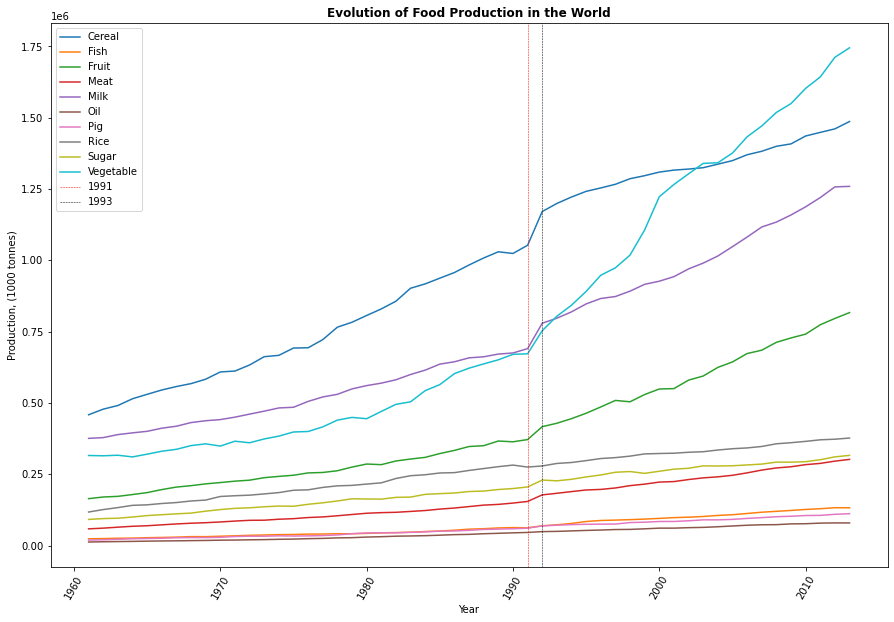

In [26]:
# Mettiamo a confronto l'andamento di produzione delle top 10 categorie di cibo
draw = ts_food.loc[ts_food['Category'].isin(top_food_category)]

figure = plt.figure(figsize=(15,10))
sns.lineplot(x="Year", y="Production", hue="Category", data=draw)

# Teniamo sempre sott'occhio l'intervallo '91 - '93, nel quale abbiamo notato una velocità maggiore di crescita
plt.axvline(1991, color='red', linestyle='--', linewidth=0.5, label='1991')
plt.axvline(1992, color='black', linestyle='--', linewidth=0.5, label='1993')

plt.title("Evolution of Food Production in the World", fontsize = 12, fontweight = "bold")
plt.xlabel("Year", fontsize = 10)
plt.ylabel("Production, (1000 tonnes)", fontsize = 10)
plt.xticks(rotation=60)
plt.legend()
plt.show()

#### Osservazione

Da questo grafico possiamo apprezzare:
* La crescita esponenziale della produzione di verdure, tanto da aver superato persino la produzione di cereali;
* Il picco di velocità di crescita tra il '91 ed il '93 per alcune categorie (es: cereali, latte);
* La netta distanza tra verdure/cereali e carne rossa/maiale. 

Vorremmo però avere un confronto visivo migliore della crescita di queste 10 categorie, quindi passiamo ad una scala logaritmica.

C:\Users\User\AppData\Local\Temp\ipykernel_8640\1234671444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw['Production'] = np.log10(draw['Production'])


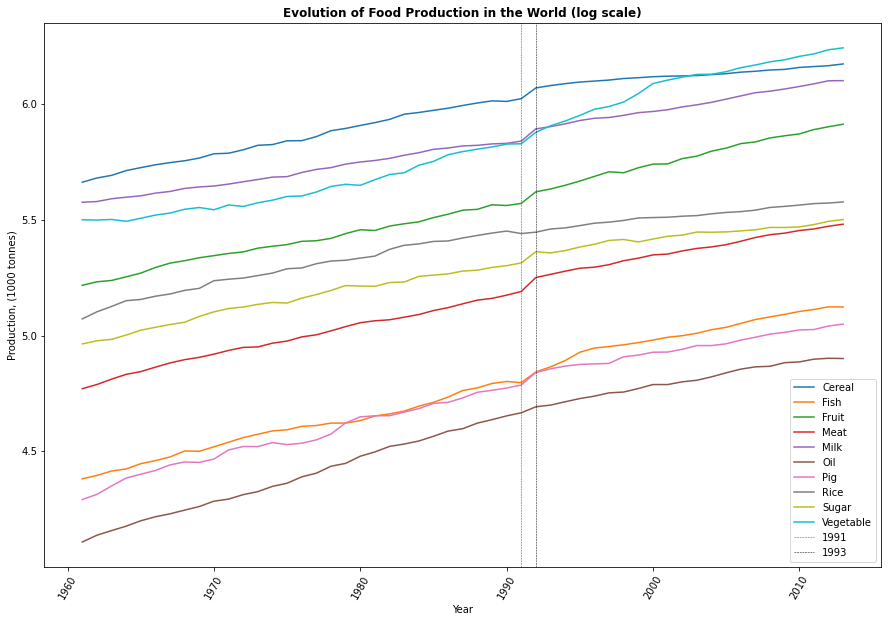

In [27]:
draw = ts_food.loc[ts_food['Category'].isin(top_food_category)]
draw['Production'] = np.log10(draw['Production'])

figure = plt.figure(figsize=(15,10))
sns.lineplot(x="Year", y="Production", hue="Category", data=draw)

plt.axvline(1991, color='red', linestyle='--', linewidth=0.5, label='1991')
plt.axvline(1992, color='black', linestyle='--', linewidth=0.5, label='1993')

plt.title("Evolution of Food Production in the World (log scale)", fontsize = 12, fontweight = "bold")
plt.xlabel("Year", fontsize = 10)
plt.ylabel("Production, (1000 tonnes)", fontsize = 10)
plt.xticks(rotation=60)
plt.legend()
plt.show()

#### Osservazione

Grazie alla scala logaritmica possiamo apprezzare meglio la crecsita delle varie categorie.
In particolare, notiamo come certe categorie abbiano avuto una crescita più lenta dal '93 in poi (es: riso, zucchero, cereali).

-----------------------------------------------------------------

Iteriamo gli stessi passaggi per i mangimi adesso.

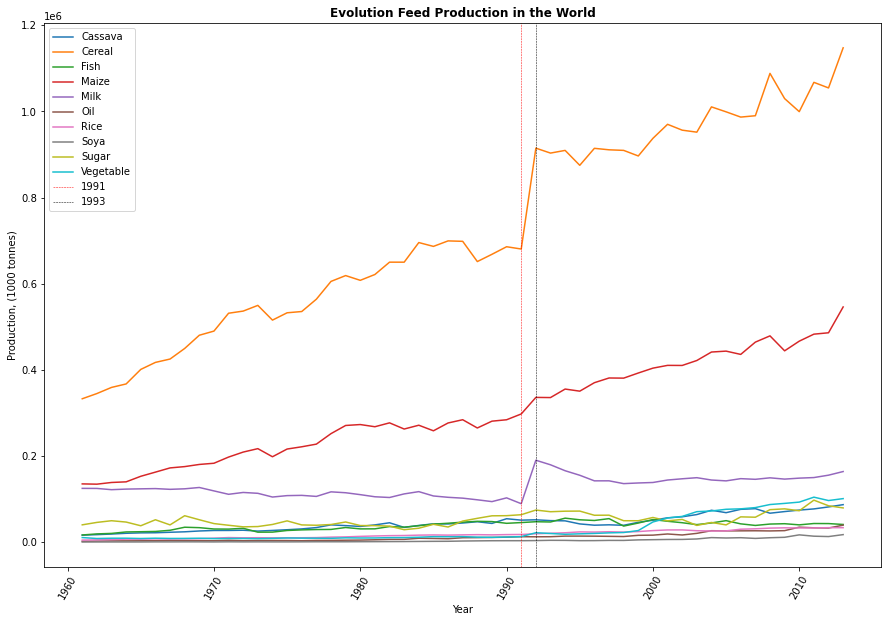

In [28]:
draw = ts_feed.loc[ts_feed['Category'].isin(top_feed_category)]

figure = plt.figure(figsize=(15,10))
sns.lineplot(x="Year", y="Production", hue="Category", data=draw)

plt.axvline(1991, color='red', linestyle='--', linewidth=0.5, label='1991')
plt.axvline(1992, color='black', linestyle='--', linewidth=0.5, label='1993')

plt.title("Evolution Feed Production in the World", fontsize = 12, fontweight = "bold")
plt.xlabel("Year", fontsize = 10)
plt.ylabel("Production, (1000 tonnes)", fontsize = 10)
plt.xticks(rotation=60)
plt.legend()
plt.show()

#### Osservazione

Al contrario di quanto visto per il cibo, l'andamento dei mangimi è più frastagliato. Abbiamo, infatti, periodi di crescita alternati a quelli di decrescita. Ma, anche in questo caso, possiamo notare dei picchi di crescita tra il '91 ed il '93 (es: cereali, latte) che coincide, come ci aspetteremmo, con una crescita di produzione più rapida di carne (rossa e di maiale).

Applichiamo una scala logaritmica per poter confrontare meglio le varie categorie.

C:\Users\User\AppData\Local\Temp\ipykernel_8640\4061901844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw['Production'] = np.log10(draw['Production'])


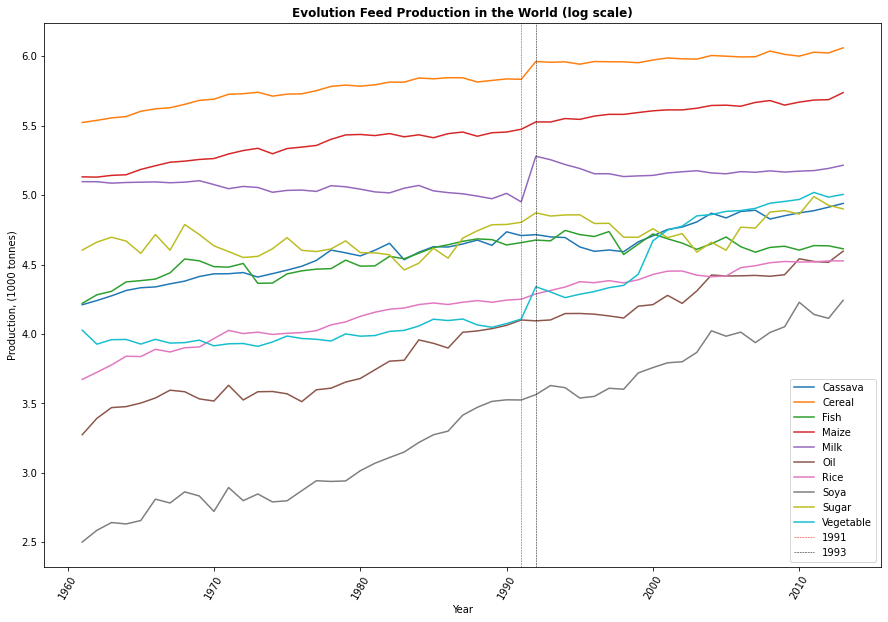

In [29]:
draw = ts_feed.loc[ts_feed['Category'].isin(top_feed_category)]
draw['Production'] = np.log10(draw['Production'])

figure = plt.figure(figsize=(15,10))
sns.lineplot(x="Year", y="Production", hue="Category", data=draw)

plt.axvline(1991, color='red', linestyle='--', linewidth=0.5, label='1991')
plt.axvline(1992, color='black', linestyle='--', linewidth=0.5, label='1993')

plt.title("Evolution Feed Production in the World (log scale)", fontsize = 12, fontweight = "bold")
plt.xlabel("Year", fontsize = 10)
plt.ylabel("Production, (1000 tonnes)", fontsize = 10)
plt.xticks(rotation=60)
plt.legend()
plt.show()

### Conclusione

Nonostante il latte e la carne occupino rispettivamente il terzo ed il nono posto a livello di produzione mondiale, sono proprio queste due categorie ad incidere maggiormente per impatto ambientale. Va sottolineata anche l'enorme differenze tra queste prime due categorie e la terza (frutta): in scala logaritmica vi è una differenza pari (circa) a 1, che si traduce in una differenza in scala di valori da $10^{9}$ a $10^{8}$!

Non basterà, quindi, avere una crescita esponenziale produttiva delle verdure (forse dovuta al sempre più diffondersi delle diete vegane?) se non viene accompagnata da una forte decrescita per quanto riguarda latte e carne.

Non possiamo neanche trascurare l'impatto dei mangimi, infatti:

In [32]:
ratio = sum_feed_impact / (sum_food_impact + sum_feed_impact)
percentage = (ratio*100).round(2)
print(f"Il mangime costituisce l'{percentage}% delle emissioni totali di CO2.")

Il mangime costituisce l'11.84% delle emissioni totali di CO2.


Tale percentuale può essere ridotta solo diminuendo la produzione di carne. 

-------------------------------------------------------------------------

#### Curiosità

Possiamo, infine, sfatare il "falso mito della soia non sostenibile" - già sfatato dalla Dotteressa Goggi ([video](https://www.youtube.com/watch?v=isywUjdCxmw)) - infatti non solo non rientra tra le categorie di cibo più prodotte, ma l'impatto ambientale che ha è così grande proprio perché usato come mangime!